# SMPL

The SMPL model decomposes body shape into identity-dependent shape and non-rigid pose-dependent shape and takes a vertex-based skinning approach that uses corrective blend shapes. A single blend shape is represented as a vector of concatenated vertex offsets. We begin with an artist-created mesh with $N=6890$ vertices and $K = 23$ joints. The mesh has the same topology for men and women, spatially varying resolution, a clean quad structure, a segmentation into parts, initial blend weights, and a skeletal rig.

The model is defined by a mean template shape represented by a vector of *N* concatenated vertices $\overline{T} \in R^{3N}$ in the zero pose, $\overrightarrow{\theta}^{*}$; a set of blend weights *W* $ \in R^{N x K}$ (a); a blend shape function, $B_{S}(\overrightarrow{\beta}):R^{|\overrightarrow{\beta}|}\to R^{3N}$ that takes as input a vector of shape parameters $\overrightarrow{\beta}$ and otuptus a blend shape sculpting the subject identity; a function to predict $K$ joint locations (white dots) $J(\overrightarrow{\beta}):R^{|\overrightarrow{\beta}|} \to R^{3K}$; and a pose-dependent blend shape funciton $B_{P}(\overrightarrow{\theta}):R^{|\overrightarrow{\theta}|} \to R^{3N}$ that accounts for the effects of pose-dependent deformations. The corrective blend shapes of these functions are added together in the rest pose. Finally, a standard blend skinning function $W(·)$ is applied to rotate the vertices around the estimated joint centers with smoothing defined by the blend weights.

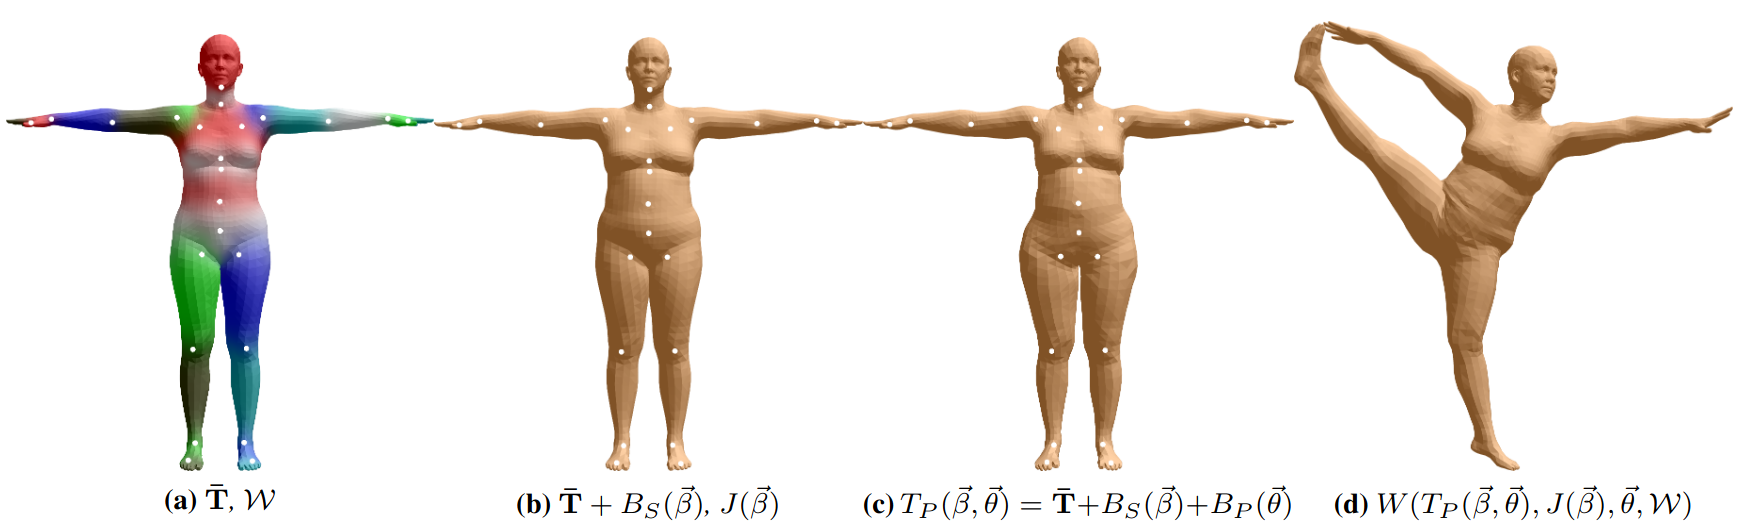

The result is a model $M(\overrightarrow{\beta}, \overrightarrow{\theta}, \Phi):R^{|\overrightarrow{\theta}|x|\overrightarrow{\beta}|} \to R^{3N}$ that maps shape and pose parameters to vertices.  Here $\Phi$ represents the learned model parameters.

The pose of the body is defined by a standard skeletal rig, where
$\overrightarrow{\omega}_{k} \in R^{3}$ denotes the axis-angle representation of the relative rotation of part $k$ with respect to its parent in the kinematic tree. SMPL rig has $K=23$ joints, hence a pose $\overrightarrow{\theta}=[\overrightarrow{\omega}_{0},...,\overrightarrow{\omega}_{K}]$ is defined by $|\overrightarrow{\omega}|=3 x 23+3=72$ parameters; i.e. 3 for each part plus 3 for the root orientation. The axis angle for every joint $j$ is transformed to a rotation matrix using rodrigues formula.

# HybrIK

HybrIK bridges the gap between body mesh estimation and 3D keypoint estimation. Proposes a novel hybrid inverse kinematics solution (HybrIK) that directly transforms accurate 3D joints to relative body-part rotations for 3D body mesh reconstruction, via the twist-and-swing decomposition. The swing rotation is analytically solved with 3D joints, and the twist rotation is derived from the visual cues through the neural network.

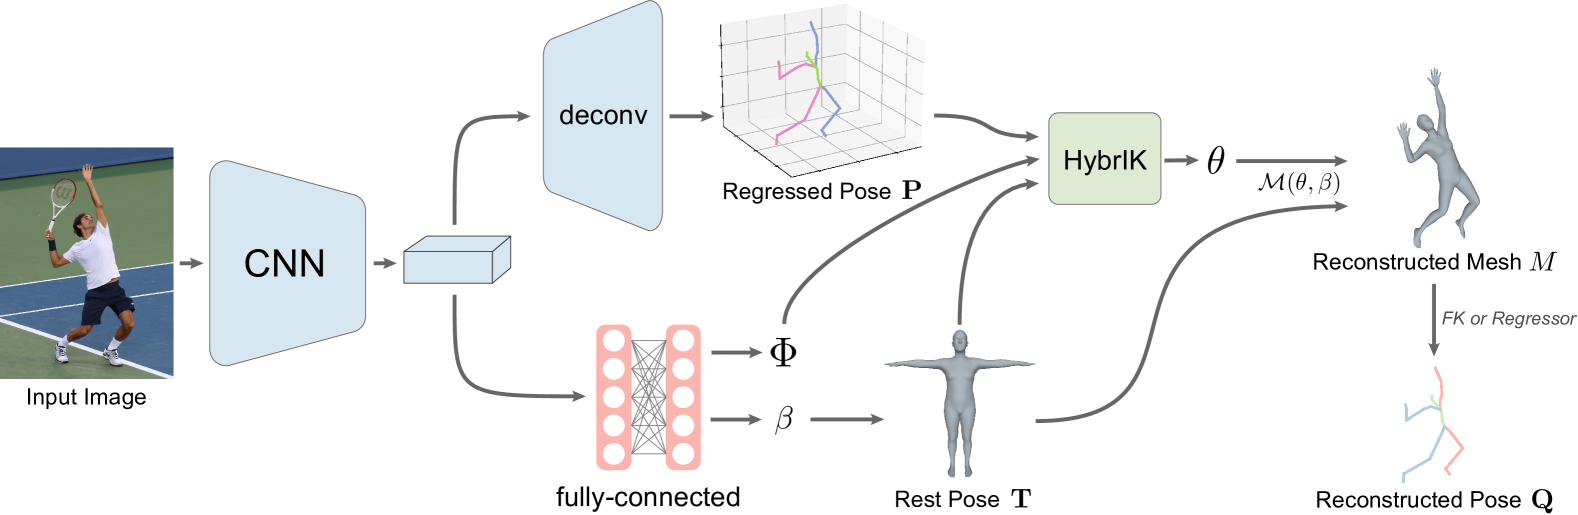

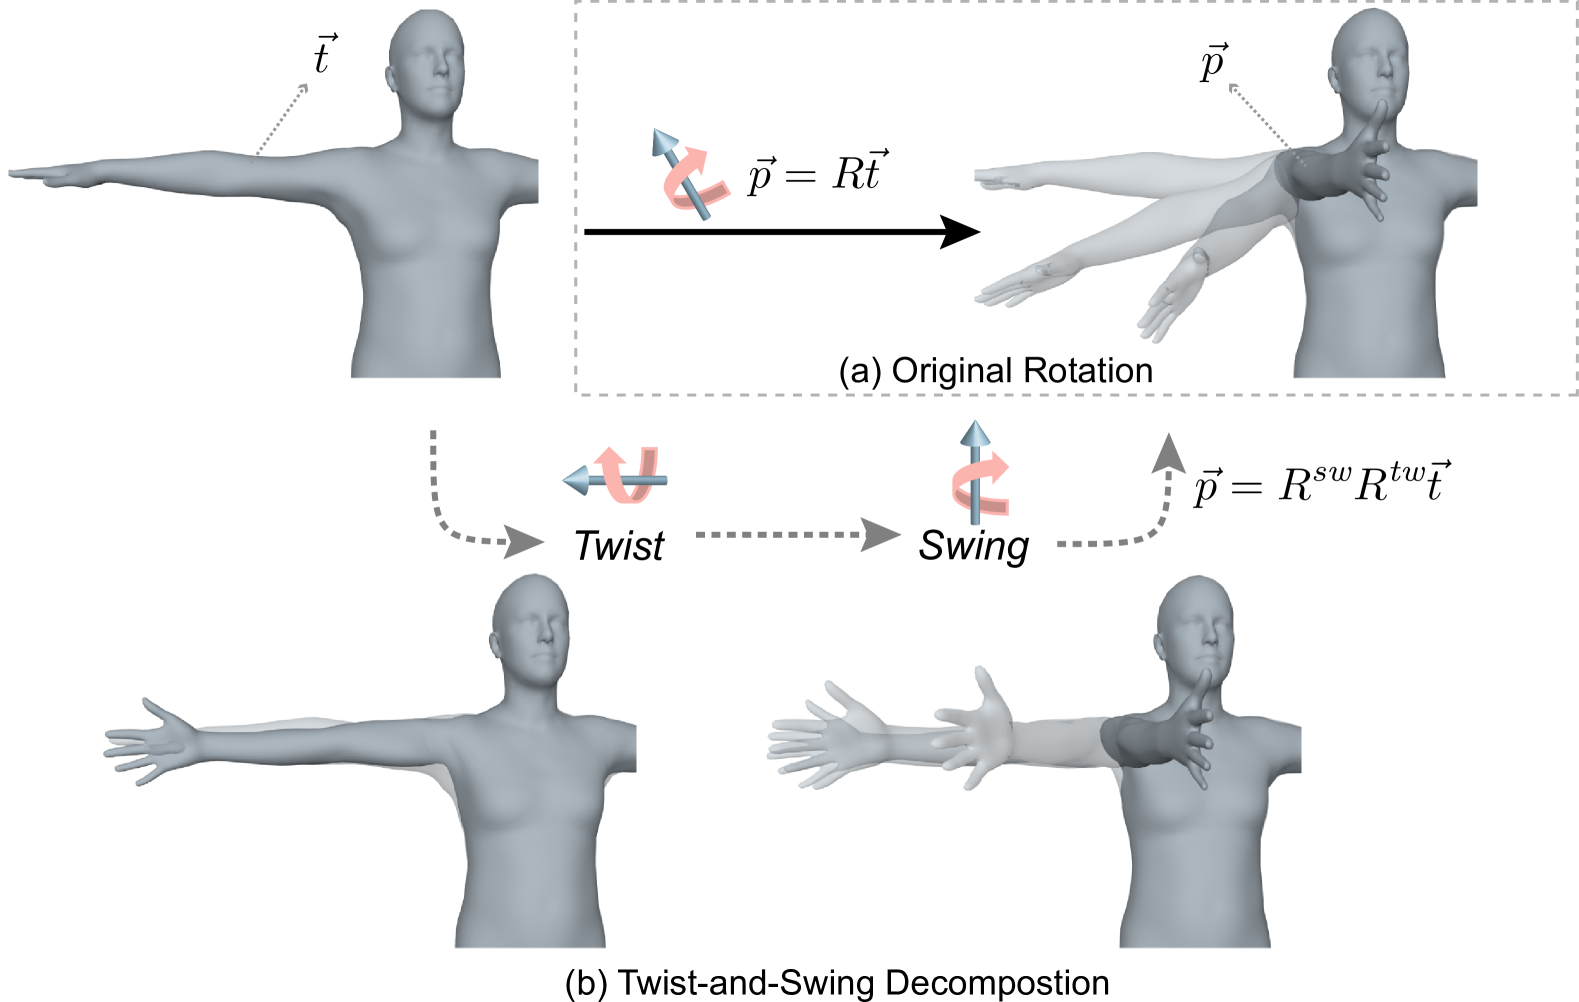

In [26]:
import sys
sys.path.append("../../src")
from hybrik_wrapper import HybrIK

hybrik_wrapper = HybrIK()

Using cache found in /home/enzo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-10 Python-3.8.13 torch-1.10.1+cu102 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6075MiB)

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 


Loading model from /home/enzo/eidos-motion/src/pretrained_hrnet.pth...


In [27]:
frame_path = "../data/processed/videos/Walking/raw_images/Walking-000001.png"

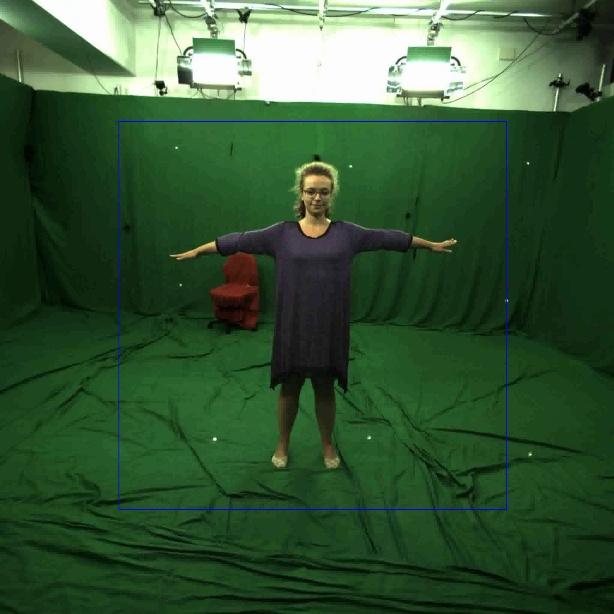

In [56]:
import cv2
import torch
import numpy as np
import IPython

def center_scale_to_box(center, scale):
    pixel_std = 1.0
    w = scale[0] * pixel_std
    h = scale[1] * pixel_std
    xmin = center[0] - w * 0.5
    ymin = center[1] - h * 0.5
    xmax = xmin + w
    ymax = ymin + h
    bbox = [xmin, ymin, xmax, ymax]
    return bbox

def render_bbox_xywh(img, bbox):
    x1 = int(bbox[0] - bbox[2]/2)
    y1 = int(bbox[1] - bbox[3]/2)
    x2 = int(bbox[0] + bbox[2]/2)
    y2 = int(bbox[1] + bbox[3]/2)

    output = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

    return output

def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# read frame from path into numpy array and change channel order from bgr to rgb
frame = cv2.imread(frame_path)

# Run object detection and bbox pre processing
hybrik_wrapper.prev_bbox = None
bbox, rgb_frame = hybrik_wrapper.detect_person(frame)
# scale bbox and change aspect ratio
_, bbox_center, bbox_wh = hybrik_wrapper.transform_bbox(bbox)
bbox_xywh = np.array([bbox_center[0], bbox_center[1], bbox_wh[0], bbox_wh[1]])
imshow(cv2.resize(render_bbox_xywh(frame, bbox_xywh), (0,0), fx=0.3, fy=0.3))

# Transform input frame
pose_input, img_center = hybrik_wrapper.transform_frame(rgb_frame,
                                                        bbox_xywh[:2],
                                                        bbox_xywh[2:])

# Run HRNet + HybrIK
bbox_xyxy = center_scale_to_box(bbox_xywh[:2], bbox_xywh[2:])
pose_output = hybrik_wrapper.model(
                        pose_input, flip_test=False,
                        bboxes=torch.from_numpy(np.array(bbox_xyxy)).to(pose_input.device).unsqueeze(0).float(),
                        img_center=torch.from_numpy(img_center).to(pose_input.device).unsqueeze(0).float())

# Obtain root position (transl), joints orientations (joints_orients), root orientation (root_orient)
# and shape parameters (beta)
transl = pose_output.transl.detach()
transl[:, 2] = transl[:, 2] * 256 / bbox_xywh[2]
transl = transl.unsqueeze(1)

joints_orients = pose_output.pred_theta_mats[:, 4:].detach()

root_orient = pose_output.pred_theta_mats[:, 0:4].detach()

beta = pose_output.pred_delta_shape.detach()

In [57]:
print(transl)
print(beta.shape)
print(joints_orients.shape)
print(root_orient)

tensor([[[0.02776, 0.02056, 1.62809]]], device='cuda:0')
torch.Size([1, 10])
torch.Size([1, 92])
tensor([[-0.07741,  0.99673,  0.02250,  0.00536]], device='cuda:0')


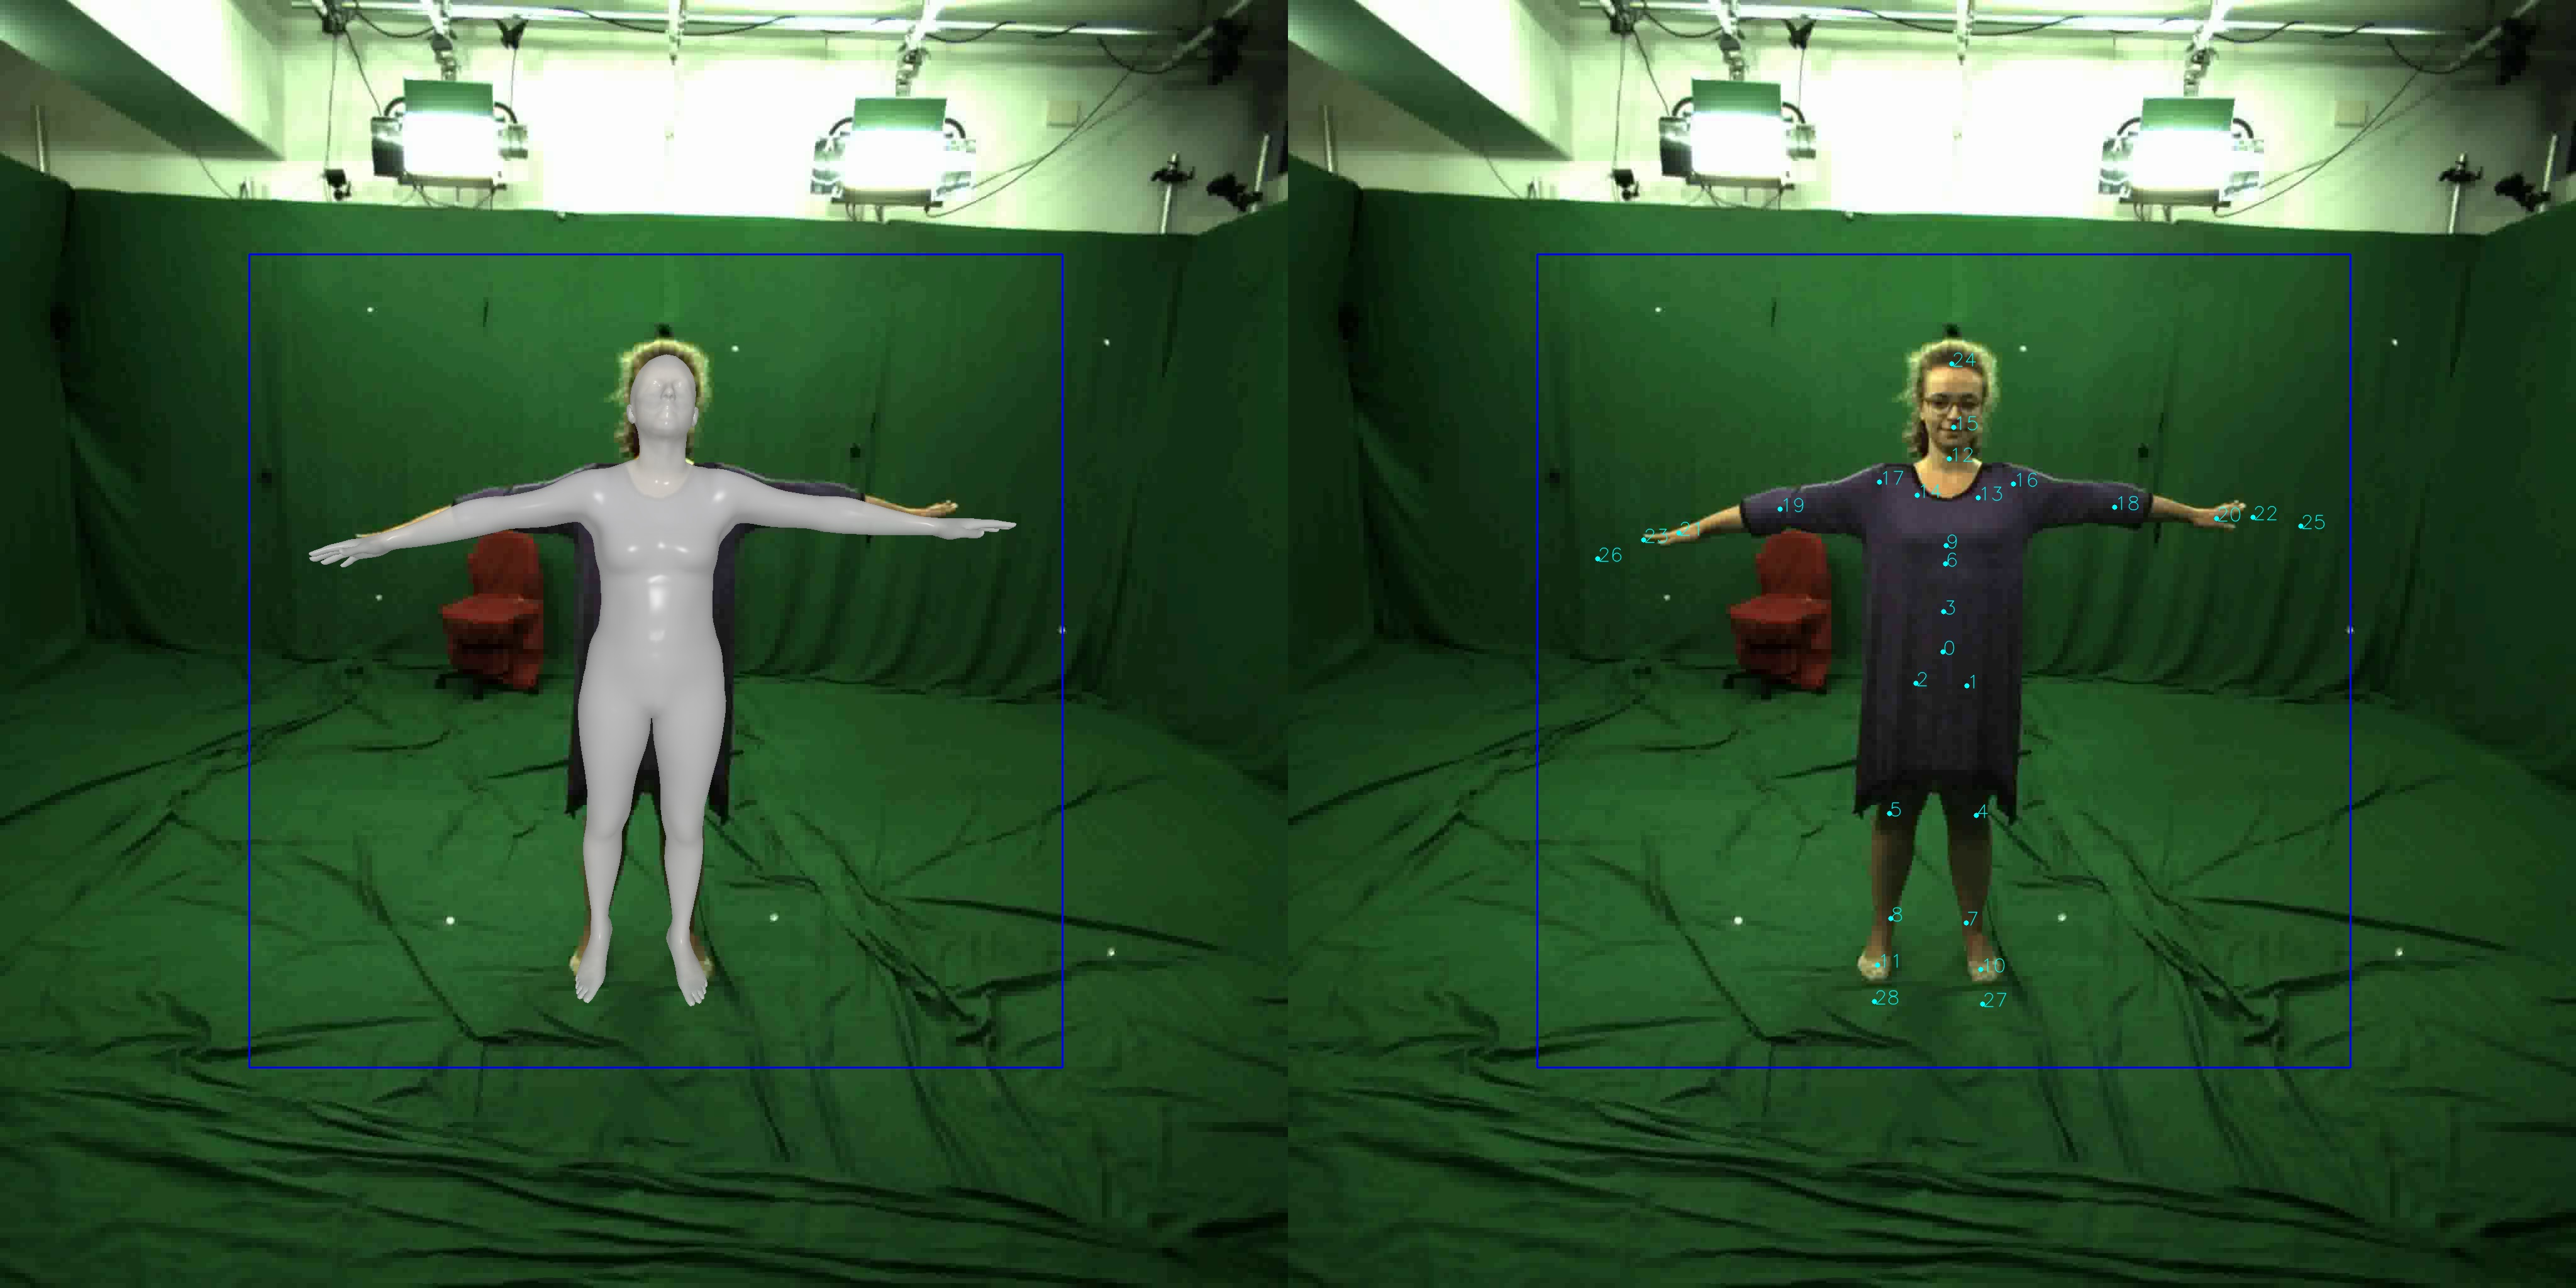

In [60]:
from pytorch3d.transforms.rotation_conversions import quaternion_multiply

def rotate_quat_x_pi(quats: torch.Tensor) -> torch.Tensor:
    rot_quat = torch.zeros_like(quats)
    rot_quat[:, :, 1] = 1

    return quaternion_multiply(rot_quat, quats)

# render keypoints and vertices from joints angles (quaternions), transl and beta
input_h, input_w, _ = frame.shape
output_wrapper = np.zeros((input_h, input_w*2, 3), dtype=np.uint8)

joints_orients = joints_orients.reshape(1, 23, 4)

root_orient = root_orient.reshape(1, 1, 4)
# Rotate root orientation pi degrees in x axis
root_orient = rotate_quat_x_pi(root_orient)

wrapper_vertices, wrapper_kps = hybrik_wrapper.smpl_forward(joints_orients, beta, root_orient=root_orient)

Oy, Ox, _ = (np.array(frame.shape)/2).tolist()
princpt = torch.Tensor([[Ox, Oy]]).to(hybrik_wrapper.device)
wrapper_rendered_vertices = hybrik_wrapper.render_vertices(wrapper_vertices, transl, 1000, frame.copy())
wrapper_2d_kps = hybrik_wrapper.project_kps(wrapper_kps, princpt, t=transl)
wrapper_rendered_kps = hybrik_wrapper.render_kps(wrapper_2d_kps, frame.copy())
output_wrapper[:, 0:input_w, :] = wrapper_rendered_vertices
output_wrapper[:, input_w:, :] = wrapper_rendered_kps

imshow(output_wrapper)

# Quaternions

Quaternions are mathematical operators that are used to rotate and stretch vectors.

Accurately locating, shifting, and rotating objects in space can be done in a variety of ways. The more familiar and easy to visualize roll, pitch, and yaw are limited and should be replaced in certain cases with the more robust quaternion.

Unit quaternions, known as versors, provide a convenient mathematical notation for representing spatial orientations and rotations of elements in three dimensional space. Specifically, they encode information about an axis-angle rotation about an arbitrary axis. when used to represent rotation, unit quaternions are also called rotation quaternions. When used to represent an orientation (rotation relative to a reference coordinate system), they are called orientation quaternions

A rotation of angle $\theta$ around the axis defined by the unit vector $\overrightarrow{u}=(u_{x}, u_{y}, u_{z})=u_{x}\mathbf{i}+u_{y}\mathbf{j}+u_{z}\mathbf{k}$ can be represetended by a quaternion $\mathbf{q}=cos(\theta/2)+(u_{x}\mathbf{i}+u_{y}\mathbf{j}+u_{z}\mathbf{k})sin(\theta/2)$

The desired rotation can be applied to an ordinary vector $\mathbf{p}=(p_{x},p_{y},p_{z})=p_{x}\mathbf{i}+p_{y}\mathbf{j}+p_{z}\mathbf{k}$ in 3-dimensional space, considered as a quaternion with a real coordinate equal to zero, by evaluating the conjugation of p by q: $\mathbf{p'}=\mathbf{q}\mathbf{p}\mathbf{q}^{-1}$ where $\mathbf{q}^{-1}=cos(\theta/2)-(u_{x}\mathbf{i}+u_{y}\mathbf{j}+u_{z}\mathbf{k})sin(\theta/2)$.

Two rotation quaternions can be combined into one equivalent quaternion by the relation $\mathbf{q'}=\mathbf{q_{2}}\mathbf{q_{1}}$ in which $\mathbf{q'}$ corresponds to the rotation $\mathbf{q_{1}}$ followed by the rotation $\mathbf{q_{2}}$. Thus, an arbitrary number of rotations can be composed together and then applied as a single rotation. 

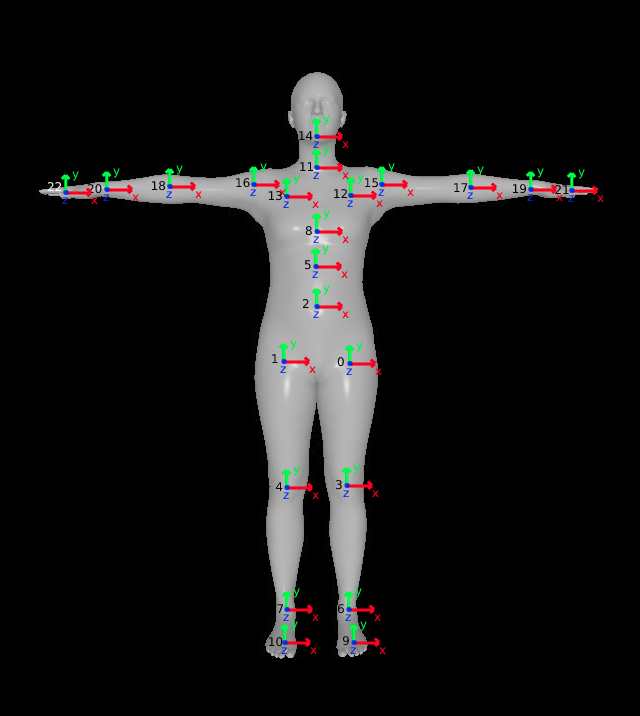